In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup
import seaborn as sns
import scipy.stats
import numpy as np
from collections import Counter
from statsmodels.formula.api import ols
from statsmodels.formula.api import gls
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression
from scipy import stats



In [2]:
os.listdir()

['Covid_ESRD_v3.ipynb',
 'geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.dbf',
 'Untitled1.ipynb',
 '.DS_Store',
 'ESRD_COVID_data_May08.xlsx',
 'Untitled.ipynb',
 'chicago_zip_covid.csv',
 'Impact of poverty and race on pre-end-stage renal disease care among dialysis patients in the United States.pdf',
 'Covid_ESRD_v2.ipynb',
 'ESRD_COVID_data_May03.xlsx',
 'chicago_zip_covid_May_9.csv',
 'geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.shx',
 'geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.shp',
 'Covid_ESRD.ipynb',
 'chicago_zip_covid_May_6.csv',
 'Time trends in the association of ESRD incidence with area‐level poverty in the US population.pdf',
 '.ipynb_checkpoints',
 'main_dataframe.csv',
 'Chicago_covid.ipynb',
 'geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.prj']

# Functions

In [3]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# Load and Prepare

In [4]:
# Get latest data for IDPH
df_chicago_zip_covid_latest = pd.read_csv('chicago_zip_covid_May_9.csv').\
        rename(columns = {'Zip':'il_zip',
                          'Tested':'total_tested',
                          'Positive Cases':'total_positive'})
print(df_chicago_zip_covid_latest.shape)
print()
df_chicago_zip_covid_latest.tail()

(471, 3)



,il_zip,total_tested,total_positive
466,62920,83,20
467,62948,204,6
468,62959,480,23
469,62966,324,40
470,62992,54,20


In [5]:
# Get demographics and poverty Data
df_chicago_zip_covid = pd.read_excel('ESRD_COVID_data_May08.xlsx').rename(columns = {'percent_hisp_or_latino_any_race':
                                                                         'percent_hispanic'})
df_chicago_zip_covid = df_chicago_zip_covid.query("tot_pop > 0")
print(df_chicago_zip_covid.shape)

(1382, 23)


In [6]:
# Combine data 
# Combine Data 
df_main = df_chicago_zip_covid.merge(df_chicago_zip_covid_latest, 
                                     on='il_zip', 
                                     how = 'inner').dropna()
print(df_main.shape)
df_main.drop(['positive_COVID_cases', 'total_COVID_tests'], axis = 1, inplace=True)

# Restrict to Cook county
df_main = df_main.query("latitude > 41.2").query("latitude < 42.10").query("longitude > -88.3").query("longitude < -87.3")

# add derived variables
# Covid per capita
df_main['tests_per_capita'] = df_main.total_tested/df_main.tot_pop
df_main['positives_per_capita'] = df_main.total_positive/df_main.tot_pop
df_main['infection_rate'] = df_main.total_positive/df_main.total_tested

print(df_main.shape)
df_main.dropna().info()

(466, 25)
(222, 26)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 2 to 307
Data columns (total 26 columns):
il_zip                                      222 non-null int64
dialysis_centers                            222 non-null int64
total_dialysis_stations                     222 non-null int64
latitude                                    222 non-null float64
longitude                                   222 non-null float64
percent_below_poverty_line                  222 non-null float64
tot_pop                                     222 non-null int64
percent_white                               222 non-null float64
percent_black                               222 non-null float64
percent_american_indian                     222 non-null float64
percent_asian                               222 non-null float64
percent_native_hawaiian_pacific_islander    222 non-null float64
percent_some_other_race                     222 non-null float64
median_household_income               

In [7]:
df_main.head()

,il_zip,dialysis_centers,total_dialysis_stations,latitude,longitude,percent_below_poverty_line,tot_pop,percent_white,percent_black,percent_american_indian,...,perc_age_65_and_above,perc_age_75_and_above,median_age,males_per_hundred_females,perc_families_below_poverty,total_tested,total_positive,tests_per_capita,positives_per_capita,infection_rate
2,60005,2,20,42.063852,-87.985566,7.9,29539,84.4,3.0,0.5,...,20.5,9.7,43.8,103.7,5.1,522,90,0.017672,0.003047,0.172414
3,60007,3,29,42.007574,-87.993059,3.8,33420,85.1,1.6,0.7,...,18.2,8.0,43.8,97.6,3.3,643,125,0.019240,0.003740,0.194401
4,60008,1,24,42.074453,-88.022667,6.3,21833,72.9,5.4,1.5,...,14.6,7.7,37.4,94.4,4.6,499,161,0.022855,0.007374,0.322645
10,60016,0,0,42.049732,-87.891676,9.2,59637,68.1,4.3,0.9,...,17.0,8.3,41.7,93.8,7.0,2086,707,0.034978,0.011855,0.338926
11,60018,1,13,41.997463,-87.896967,13.9,30386,78.3,2.9,0.4,...,15.6,7.8,38.3,104.2,11.9,956,306,0.031462,0.010070,0.320084


In [8]:
df_main.to_csv('main_dataframe.csv')

# Testing and Stats

In [9]:
# Normality test

ks_stat = pd.DataFrame(index = df_main.columns, columns = ['stat','pvalue'])
ks_stat
for col in df_main.columns:
    x = (df_main[col] - df_main[col].mean())/df_main[col].std()
    ks_stat.loc[col,'stat'] = stats.kstest(x, 'norm').statistic
    ks_stat.loc[col,'pvalue'] = stats.kstest(x, 'norm').pvalue
ks_stat

,stat,pvalue
il_zip,0.159496,2.11863e-05
dialysis_centers,0.270281,8.15228e-15
total_dialysis_stations,0.267067,1.80452e-14
latitude,0.0975853,0.0271881
longitude,0.0971331,0.0282844
percent_below_poverty_line,0.159266,2.18977e-05
tot_pop,0.114521,0.00541932
percent_white,0.142324,0.0002187
percent_black,0.257834,1.67113e-13
percent_american_indian,0.145706,0.000141076


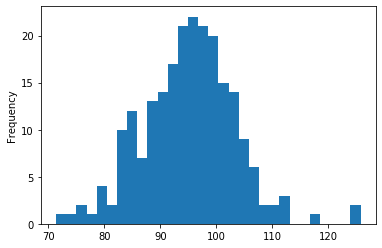

In [10]:
df_main.males_per_hundred_females.plot.hist(bins = 30)

# Correlation

Text(0.5, 0.98, 'Spearmans')

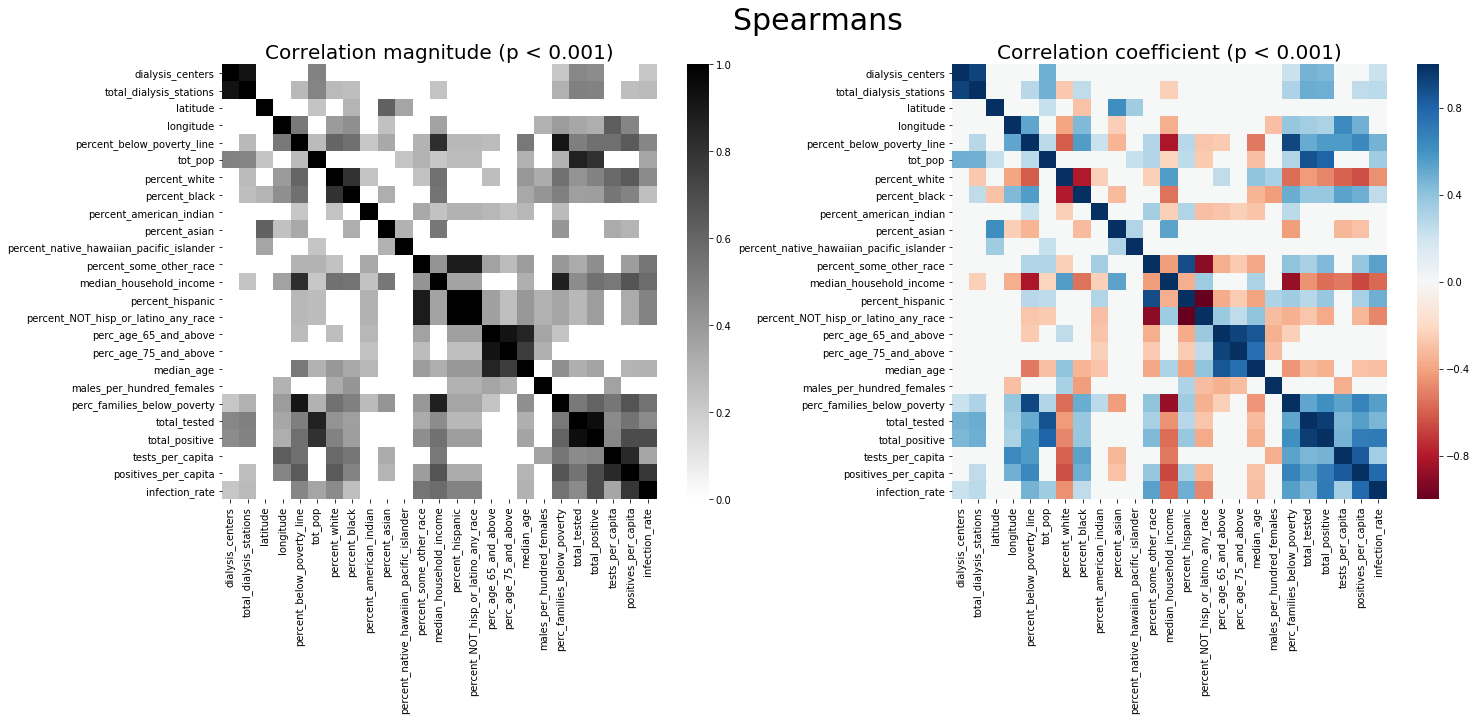

In [11]:
columns_of_interest = ['positives_per_capita','tests_per_capita', 'positive_rate', 'stations_per_center',
                       'stations_per_center','tot_pop']

pv = 0.001
df_spearman = pd.DataFrame(index = df_main.columns, columns = df_main.columns)
df_pearson = pd.DataFrame(index = df_main.columns, columns = df_main.columns)
for i,col in enumerate(df_main.columns):
    if col == 'il_zip':
        continue
    
    for j,row in enumerate(df_main.columns):
        
        if j < i:
            continue
    
        if row == 'il_zip':
            continue
        else:
            x = df_main[row]
            y = df_main[col]
            if scipy.stats.spearmanr(x,y).pvalue < pv:
                df_spearman.loc[row,col] = scipy.stats.spearmanr(x,y).correlation
                df_spearman.loc[col,row] = scipy.stats.spearmanr(y,x).correlation

            else:
                 df_spearman.loc[row,col] = 0  
                 df_spearman.loc[col,row] = 0 
                    
            if scipy.stats.pearsonr(x,y)[1] < pv:
                df_pearson.loc[row,col] = scipy.stats.pearsonr(x,y)[0]
                df_pearson.loc[col,row] = scipy.stats.pearsonr(y,x)[0]
            else:
                
                    
                df_pearson.loc[col,row] = 0
                df_pearson.loc[row,col] = 0

df_spearman = df_spearman.drop('il_zip', axis =0).drop('il_zip', axis =1).astype(float)
plt.figure(figsize = (24,8))

plt.subplot(1,2,1)
sns.heatmap(np.abs(df_spearman), vmax=1, vmin = 0, square=True, cmap = 'binary')
plt.title(f'Correlation magnitude (p < {pv})', fontsize = 20)

plt.subplot(1,2,2)
sns.heatmap(df_spearman, vmax=1, vmin = -1, square=True, cmap = 'RdBu')
plt.title(f'Correlation coefficient (p < {pv})', fontsize = 20)
plt.suptitle('Spearmans', fontsize = 30)

In [12]:
print(f'Pearson\'s Correlation at "{pv}"')
df = df_pearson[['infection_rate', 
             'positives_per_capita']].drop(['infection_rate', 
                                            'positives_per_capita',
                                            'total_tested',
                                            'total_positive',
                                            'tests_per_capita'])
df.query("infection_rate > 0 | positives_per_capita>0")

Pearson's Correlation at "0.001"


,infection_rate,positives_per_capita
total_dialysis_stations,0.244781,0.274334
latitude,0.239938,0
longitude,0,0.45362
percent_below_poverty_line,0.402686,0.597752
tot_pop,0.444282,0.311709
percent_black,0,0.464276
percent_some_other_race,0.687605,0.537952
percent_hispanic,0.667929,0.526537
perc_families_below_poverty,0.454189,0.614564


In [13]:
print(f'Spearman Rank Correlation at "{pv}"')
df = df_spearman[['infection_rate', 
             'positives_per_capita']].drop(['infection_rate', 
                                            'positives_per_capita',
                                            'total_tested',
                                            'total_positive',
                                            'tests_per_capita'])
df_significant = df.query("infection_rate > 0 | positives_per_capita>0")
df_significant = df_significant.drop(['longitude','tot_pop'])
significant_factors = list(df_significant.index)
print(significant_factors)
df_significant

Spearman Rank Correlation at "0.001"
['dialysis_centers', 'total_dialysis_stations', 'percent_below_poverty_line', 'percent_black', 'percent_some_other_race', 'percent_hispanic', 'perc_families_below_poverty']


,infection_rate,positives_per_capita
dialysis_centers,0.223950,0.000000
total_dialysis_stations,0.273329,0.257499
percent_below_poverty_line,0.476456,0.646804
percent_black,0.252365,0.486694
percent_some_other_race,0.539379,0.385168
percent_hispanic,0.484513,0.329225
perc_families_below_poverty,0.552510,0.671398


# Stratified Analysis

In [14]:
def get_quantile(x, quantiles, verbose = False):
    x_quantiles = np.zeros_like(x)
    
    if verbose:
        print()
        print("The quantiles are:",quantiles)
        print("The number of values will be:", len(quantiles)+1)
        print()

    # Get lowest qualtile
    if verbose:
        print(f"set all values below {quantiles[0]} as 1")
    x_quantiles[np.where(x<=quantiles[0])] = 1

    
    # get middle quatiles
    for q in range(len(quantiles)-1):
        if verbose:
            print()
            print(f"{q} of {len(quantiles)}")
            print(f"set all values between {quantiles[q]} and {quantiles[q+1]} as {q+2}")
        x_quantiles[np.where(x>quantiles[q])] = q+2

    # get highest qualtiles
    if verbose:
        print(f"set all values above {quantiles[-1]} as {len(quantiles)+1}")
    x_quantiles[np.where(x>quantiles[-1])] = len(quantiles)+1
    
    return x_quantiles

In [15]:
def stratify(df, strat = [0.5]):
    
    df_strat = pd.DataFrame(df).reset_index(drop=True)
    L = len(df_strat)
    print(f"Length is {L}, and columns are {df_strat.columns}")
    
    for col in df_strat.columns:
        print("columns is:", col)
        strat_col ='strat_' + col
        df_strat[strat_col] = 0
        
        quantiles = df_strat[col].quantile(strat).values 
        print(quantiles)
        for i,v in enumerate(quantiles):
            print(i,v)
            df_strat[strat_col] = df_strat[col].apply(lambda x: i+1 if x >= v else i)

    return df_strat

In [16]:
quantile_array = [0.25,0.5,0.75]
stratify_groups = significant_factors

for group in stratify_groups:
    strat = 'strat_' + group
    quantiles = df_main[group].quantile(quantile_array).values 
    x = df_main[group].values
    y = get_quantile(x, quantiles, verbose = False)
    df_main[strat] = y

In [17]:
df_main.columns

Index(['il_zip', 'dialysis_centers', 'total_dialysis_stations', 'latitude',
       'longitude', 'percent_below_poverty_line', 'tot_pop', 'percent_white',
       'percent_black', 'percent_american_indian', 'percent_asian',
       'percent_native_hawaiian_pacific_islander', 'percent_some_other_race',
       'median_household_income', 'percent_hispanic',
       'percent_NOT_hisp_or_latino_any_race', 'perc_age_65_and_above',
       'perc_age_75_and_above', 'median_age', 'males_per_hundred_females',
       'perc_families_below_poverty', 'total_tested', 'total_positive',
       'tests_per_capita', 'positives_per_capita', 'infection_rate',
       'strat_dialysis_centers', 'strat_total_dialysis_stations',
       'strat_percent_below_poverty_line', 'strat_percent_black',
       'strat_percent_some_other_race', 'strat_percent_hispanic',
       'strat_perc_families_below_poverty'],
      dtype='object')

In [18]:
stratify_groups

['dialysis_centers',
 'total_dialysis_stations',
 'percent_below_poverty_line',
 'percent_black',
 'percent_some_other_race',
 'percent_hispanic',
 'perc_families_below_poverty']

In [19]:
# Test
print(sorted(list(df_main.percent_hispanic.quantile(quantile_array))))
print(df_main.strat_percent_hispanic.value_counts())
df_main[['percent_hispanic',
         'strat_percent_hispanic']].sort_values(by = 'percent_hispanic').head(175).tail(10)

[6.3, 11.55, 22.65]
1.0    59
4.0    56
3.0    55
2.0    52
Name: strat_percent_hispanic, dtype: int64


,percent_hispanic,strat_percent_hispanic
111,22.5,3.0
102,22.7,4.0
297,22.7,4.0
169,22.7,4.0
204,22.9,4.0
117,23.5,4.0
108,24.7,4.0
4,24.9,4.0
137,26.5,4.0
92,27.3,4.0


In [20]:
formula = 'positives_per_capita ~ C(strat_percent_below_poverty_line) + \
C(strat_percent_black) + C(strat_percent_hispanic) + \
C(strat_percent_black):C(strat_percent_below_poverty_line) + \
C(strat_percent_hispanic):C(strat_percent_below_poverty_line)'
poverty_lm = ols(formula,data=df_main).fit()
table = anova_lm(poverty_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)

                                                      sum_sq     df  \
C(strat_percent_below_poverty_line)                 0.000482    3.0   
C(strat_percent_black)                              0.000123    3.0   
C(strat_percent_hispanic)                           0.000251    3.0   
C(strat_percent_black):C(strat_percent_below_po...  0.000279    9.0   
C(strat_percent_hispanic):C(strat_percent_below...  0.000062    9.0   
Residual                                            0.001599  194.0   

                                                            F        PR(>F)  
C(strat_percent_below_poverty_line)                 19.505253  4.285094e-11  
C(strat_percent_black)                               4.973569  2.395337e-03  
C(strat_percent_hispanic)                           10.163385  3.006748e-06  
C(strat_percent_black):C(strat_percent_below_po...   3.759292  2.208648e-04  
C(strat_percent_hispanic):C(strat_percent_below...   0.836424  5.833882e-01  
Residual                          

dialysis_centers
total_dialysis_stations
percent_below_poverty_line
percent_black
percent_some_other_race
percent_hispanic
perc_families_below_poverty


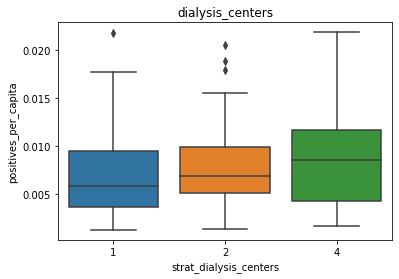

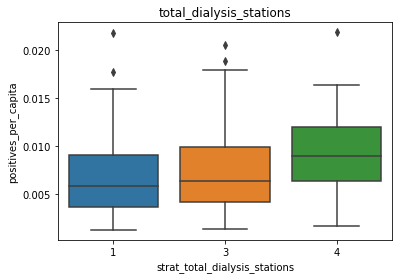

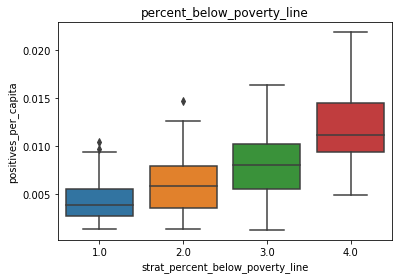

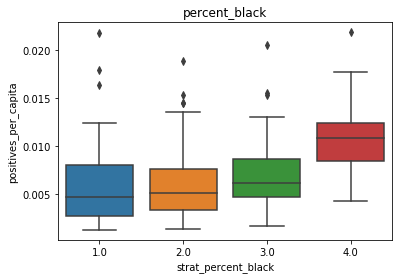

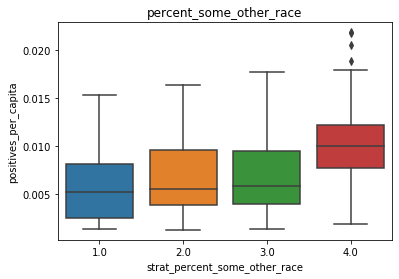

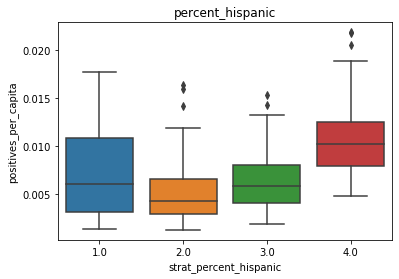

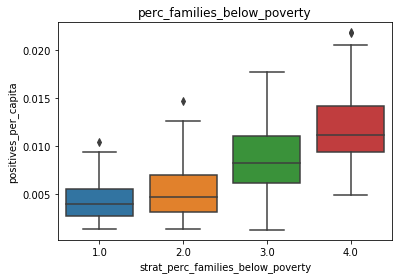

In [21]:
for group in stratify_groups:
    print(group)
    plt.figure()
    g = sns.boxplot(y = 'positives_per_capita', 
                    x = 'strat_' + group,
                   data = df_main)
    plt.title(group)



In [22]:
formula = 'infection_rate ~ C(strat_percent_below_poverty_line) + \
C(strat_percent_black) + C(strat_percent_hispanic) + \
C(strat_percent_black):C(strat_percent_below_poverty_line) + \
C(strat_percent_hispanic):C(strat_percent_below_poverty_line)'
poverty_lm = ols(formula,data=df_main).fit()
table = anova_lm(poverty_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)

                                                      sum_sq     df  \
C(strat_percent_below_poverty_line)                 0.087702    3.0   
C(strat_percent_black)                              0.000890    3.0   
C(strat_percent_hispanic)                           0.216575    3.0   
C(strat_percent_black):C(strat_percent_below_po...  0.110805    9.0   
C(strat_percent_hispanic):C(strat_percent_below...  0.032080    9.0   
Residual                                            0.607844  194.0   

                                                            F        PR(>F)  
C(strat_percent_below_poverty_line)                  9.330378  8.603738e-06  
C(strat_percent_black)                               0.094638  9.629288e-01  
C(strat_percent_hispanic)                           23.040742  8.410514e-13  
C(strat_percent_black):C(strat_percent_below_po...   3.929405  1.303019e-04  
C(strat_percent_hispanic):C(strat_percent_below...   1.137628  3.380032e-01  
Residual                          

dialysis_centers
total_dialysis_stations
percent_below_poverty_line
percent_black
percent_some_other_race
percent_hispanic
perc_families_below_poverty


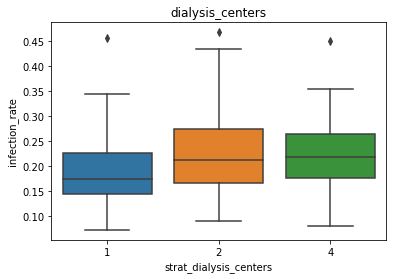

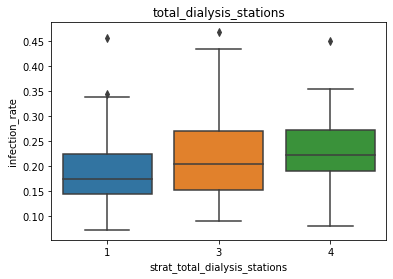

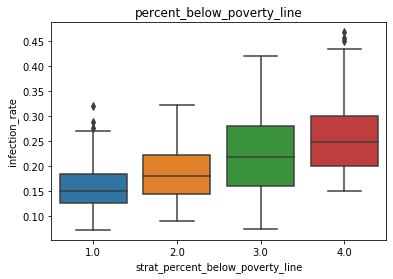

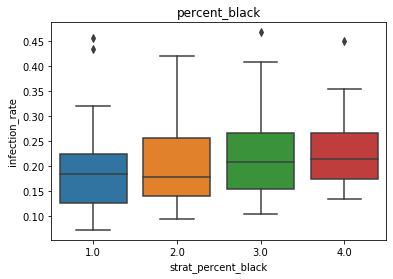

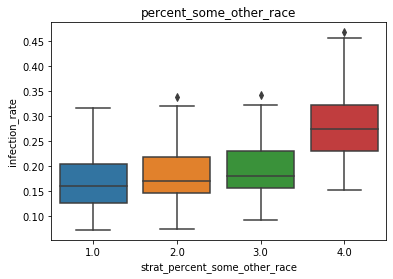

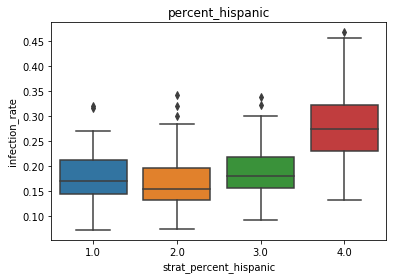

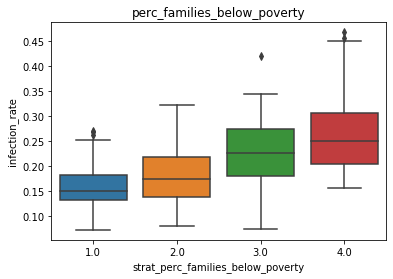

In [23]:
for group in stratify_groups:
    print(group)
    plt.figure()
    g = sns.boxplot(y = 'infection_rate', 
                    x = 'strat_' + group,
                   data = df_main)
    plt.title(group)


In [24]:
print(df_main.total_dialysis_stations.quantile(quantile_array))
df_main[['total_dialysis_stations',
         'strat_total_dialysis_stations']].sort_values(by = 
                                                       'total_dialysis_stations').head(115).tail()

0.25     0.00
0.50     0.00
0.75    21.75
Name: total_dialysis_stations, dtype: float64


,total_dialysis_stations,strat_total_dialysis_stations
103,0,1
120,0,1
116,0,1
84,1,3
149,1,3


# Does Correlation Change with Stratification?

In [25]:
df_main.head()

,il_zip,dialysis_centers,total_dialysis_stations,latitude,longitude,percent_below_poverty_line,tot_pop,percent_white,percent_black,percent_american_indian,...,tests_per_capita,positives_per_capita,infection_rate,strat_dialysis_centers,strat_total_dialysis_stations,strat_percent_below_poverty_line,strat_percent_black,strat_percent_some_other_race,strat_percent_hispanic,strat_perc_families_below_poverty
2,60005,2,20,42.063852,-87.985566,7.9,29539,84.4,3.0,0.5,...,0.017672,0.003047,0.172414,4,3,2.0,1.0,3.0,2.0,2.0
3,60007,3,29,42.007574,-87.993059,3.8,33420,85.1,1.6,0.7,...,0.019240,0.003740,0.194401,4,4,1.0,1.0,3.0,3.0,1.0
4,60008,1,24,42.074453,-88.022667,6.3,21833,72.9,5.4,1.5,...,0.022855,0.007374,0.322645,2,4,2.0,2.0,4.0,4.0,2.0
10,60016,0,0,42.049732,-87.891676,9.2,59637,68.1,4.3,0.9,...,0.034978,0.011855,0.338926,1,1,3.0,2.0,2.0,3.0,3.0
11,60018,1,13,41.997463,-87.896967,13.9,30386,78.3,2.9,0.4,...,0.031462,0.010070,0.320084,2,3,3.0,1.0,4.0,4.0,4.0


In [26]:
df_stratified_correlation = pd.DataFrame(index = significant_factors,
                                         columns = [1,2,3,4])
for factor in significant_factors:

    strata_factor = 'strat_' + factor
    for strata in sorted(list(df_main[strata_factor].unique())):
        df = df_main[df_main[strata_factor] == strata]
        x = df['positives_per_capita']
        y = df[factor]
        df_stratified_correlation.loc[factor, int(strata)] = scipy.stats.spearmanr(x,y).correlation
        
    

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


# Partial Correlations

In [27]:
significant_factors

['dialysis_centers',
 'total_dialysis_stations',
 'percent_below_poverty_line',
 'percent_black',
 'percent_some_other_race',
 'percent_hispanic',
 'perc_families_below_poverty']

In [28]:
df_main.columns

Index(['il_zip', 'dialysis_centers', 'total_dialysis_stations', 'latitude',
       'longitude', 'percent_below_poverty_line', 'tot_pop', 'percent_white',
       'percent_black', 'percent_american_indian', 'percent_asian',
       'percent_native_hawaiian_pacific_islander', 'percent_some_other_race',
       'median_household_income', 'percent_hispanic',
       'percent_NOT_hisp_or_latino_any_race', 'perc_age_65_and_above',
       'perc_age_75_and_above', 'median_age', 'males_per_hundred_females',
       'perc_families_below_poverty', 'total_tested', 'total_positive',
       'tests_per_capita', 'positives_per_capita', 'infection_rate',
       'strat_dialysis_centers', 'strat_total_dialysis_stations',
       'strat_percent_below_poverty_line', 'strat_percent_black',
       'strat_percent_some_other_race', 'strat_percent_hispanic',
       'strat_perc_families_below_poverty'],
      dtype='object')

In [29]:
import pingouin as pg
pg.partial_corr(data=df_main, x='percent_below_poverty_line', 
                y= 'positives_per_capita', covar='median_age', method='spearman').round(3)

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,222,0.625,"[0.54, 0.7]",0.391,0.385,0.0,1.0


In [30]:
import pingouin as pg
pg.partial_corr(data=df_main, x='percent_black', 
                y= 'positives_per_capita', covar='percent_white', method='spearman').round(3)

/Users/ranitsengupta/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,222,-0.243,"[-0.36, -0.12]",0.059,0.051,0.0,0.958
